# ARIMA model for prediction of stock prices

The following is code for creating an ARIMA model for weekly price forecasts of AAPLEs stock price. 

ARIMA or Automated Regressive Integrated Moving Average requires 3 parameters p,d,q

The p corresponds to the order of the Automated Regressive part of the model. Automated Regressive means it is a linear regression model as it uses its previous lags to forecast what might happen next 

The d is the order of the differencing required to make the time series stationary as ARIMA models can only work on stationary series 

The q corresponds to the order of the Moving Average which is responsible for the number of lagged forecast errors in the ARIMA


Here we import the relevant modules for the project 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

The following code contains the code required to read the stock price data from a csv file and store it in a pandas dataframe so it is easier to manipulate and use later on.

Note: The data is weekly data for our chosen stock (apple) which means later on when we predict our unit for predictions shall be weeks. This means predicting 1 step in the future is equivalent to forecasting a week in the future

In [2]:
stock = pd.read_csv('AAPL.csv')
stock = stock[['Date', 'Close']]
stock['Date'] = pd.to_datetime(stock['Date']) #weekly data


### Augmented Dickey Fuller test

The ARIMA model requires the time series to be stationary. For a preocess to be stationary it requires the mean and variance to be constant over time and for the series to have no trends. 

One way we can determine if a series is stationary or not is by performing the Augmented Dickey Fuller test which is esssentially a hypothesis test that tests for unit roots(features of stochastic processes that can cause unwanted results when forecasting time series). 

The  null hypothesis is that there is a unit root present and this is rejected when the p value returned by the ADF test is less than 5% meaning that there is sufficient evidence to support the alternative hypothesis which is that the series is stationary

In [3]:
stationary_check = adfuller(stock['Close'])
print(f"The p value is {stationary_check[1]}")#This is >0.05 so insufficient evidence to reject the null hypothesis. Thus not stationary.

The p value is 0.9901440834693515


Furthermore, just by looking at the plot of our data below we can see that the series is not stationary as there is a very clear upwards trend 

<AxesSubplot:title={'center':'Original Series'}, xlabel='Date'>

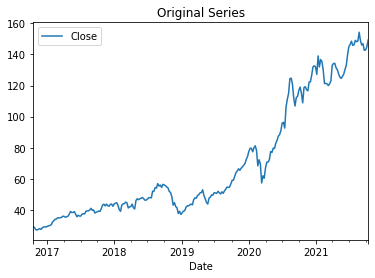

In [4]:
#Original Stock Data
stock.plot('Date', 'Close', title = "Original Series")

Now that we know our series is not stationary we must make it stationary. We can do this by differencing which is essentially subtracting previous values from the current value and is the 'd' in the ARIMA model. Below we take the first difference and remove any NAN values from the data

We can see that there is no obvious trend anymore and the series seems to fit the other stationary criteria hence, there is no need to difference multiple times

<AxesSubplot:title={'center':'First order differenced'}>

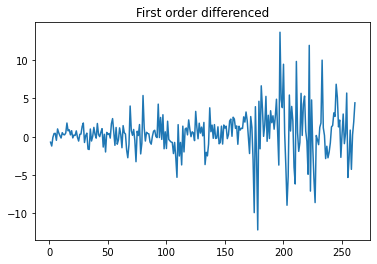

In [5]:
first_diff = stock['Close'].diff().dropna()
first_diff.plot(title = "First order differenced")

Although the first order series looks good its better to have a more definitive answer so we repeat the ADF test once again and this time the value < 0.05 thus we have suffcicient evidence to reject the null hypotheses and can say the series is stationary 

In [6]:
stationary_check = adfuller(first_diff)
print(f"The p value is {stationary_check[1]}")#This is <0.05 so the series is stationary


The p value is 3.0546982824618687e-28


### Finding p for the AR term


Next we need to find the p(lag) value for our AR (Autoregressive) term to do this we can look at the partial autocorrelation graph which essentially shows the correlation between the series and its lags without taking into account the effect on correlation from previous lags. From the PACF for the first order difference below we can see the first significant lag is p = 5 hence, we set this as our p term

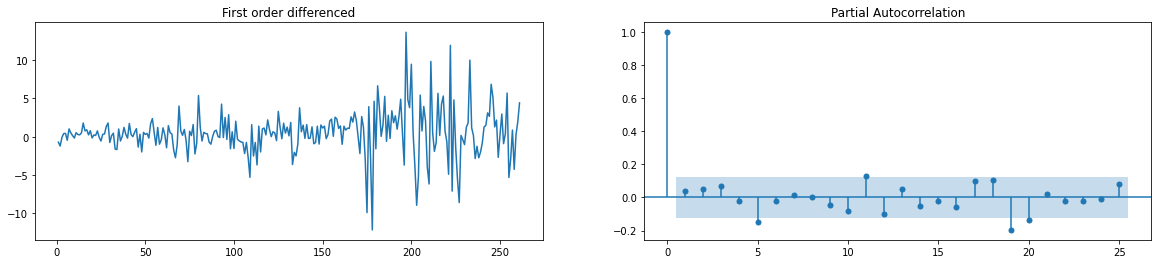

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize= (20,4 ))
first_diff.plot(ax = ax1, title = "First order differenced")
plot_pacf(first_diff, ax = ax2); #take p is 5

### Finding q for MA term 


We now need to find the lag for MA which is the Moving average part of our model. We can do this in a similar way but this time we use the Autocorrelation plot which is similar to the PACF but accounts for the correlation made by other lags. From our ACF plot below we can see that a significant lag exists at the q = 5 hence this will be the q term for our model

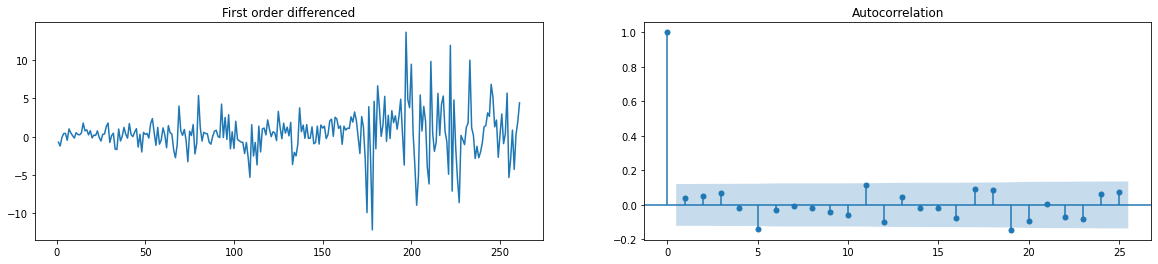

In [8]:
#First difference
fig, (ax1,ax2) = plt.subplots(1,2, figsize= (20,4 ))
first_diff.plot(ax = ax1, title = "First order differenced")
plot_acf(first_diff, ax = ax2); #take q is 5

### Fitting model

It is now time to make our model as we have all the required values. To do thi, we use our statsmodels modeule which we used previously for the PACF and ACF and use the ARIMA class with our stock close values being the data and the order of the pdq values being 5,1,5 from our analysis above. 

We then fit this model and print out a summary of the data that could be useed to make the model better or fine tune some of the p,d,q values

In [9]:
model = ARIMA(stock['Close'], order=(5,1,5))
model_fit = model.fit()
print(model_fit.summary())

/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  261
Model:                 ARIMA(5, 1, 5)   Log Likelihood                -639.782
Method:                       css-mle   S.D. of innovations              2.777
Date:                Sat, 23 Oct 2021   AIC                           1303.564
Time:                        17:43:11   BIC                           1346.338
Sample:                             1   HQIC                          1320.758
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4600      0.113      4.084      0.000       0.239       0.681
ar.L1.D.Close    -0.1485      0.080     -1.857      0.063      -0.305       0.008
ar.L2.D.Close     0.2005      0.079     

/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.A

We can then see how well our model works by splitting out data into testing and training data. The training date is 75% of the entire dataset and we will use the testing data which is the remaining 25% to see how well our model performs. 


After splitting the data set up we create the model and fit it on our data with the same parameters and before and forecast the steps equivalent to the length of the test set from the end of the training set effectively making up the whole dataset

In [10]:
train = stock.Close[:196]
test = stock.Close[196:]
modelerror = ARIMA(train, order = (5,1,5))
model_fit = modelerror.fit()
predictions ,_,_ = model_fit.forecast(len(test))


/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_mod

Next we can use the mean average percentage error to figure out the accuracy of our model. To do this we use the predictions which were stored in the predictions variable and were also what was the output of out model.forecast() with the true values from the test dataset we made earlier. 

As we can see the MAPE is 14.4% meaning that our model is 85.6% accurate on the testing data 

In [11]:
np.mean(np.abs(predictions - test)/np.abs(test)) #85.6% accuracy in predicting next 65 units of data on test set #MAPE

0.14410771817845144

Below is the graphical representation of our model on the test set. 
The method to get the forecasts remains unchanged but this time we change the predicitions into a dataframe so we can change the index from 0 to the end of the training set so that the predictions lead off the end of the training set. 

The line in blue is the training data

The line in yellow is the testing data

The line in red is the forecasted values

/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


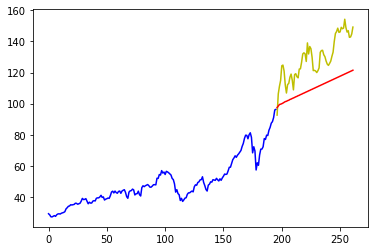

In [12]:
model = ARIMA(train, order=(5,1,5))
model_fit = model.fit()
predictions_error,_,_ = model_fit.forecast(len(test))
pd.DataFrame(predictions_error)
plt.plot(train, color = 'b')
plt.plot(test, color = 'y')
df = pd.DataFrame(predictions_error)
df.index = df.index + len(train)
plt.plot(df, color = 'r')

### Forecasting the next 4 weeks using our model


Bellow is the forecast for the next 4 weeks as this is effectively the units of our model as the data fed in was weekly

The colour coding is the same as above but with no testing data as this is with the whole set

/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/shantanusharma/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.A

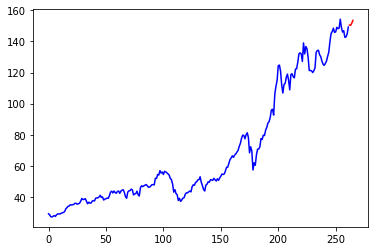

In [13]:
model = ARIMA(stock['Close'], order=(5,1,5))
model_fit = model.fit()
predictions_final,_,_ = model_fit.forecast(4)
pd.DataFrame(predictions_final)
plt.plot(stock['Close'], color = 'b')
df = pd.DataFrame(predictions_final)
df.index = df.index + len(stock['Close'])
plt.plot(df, color = 'r')


### To get price prediction

Below are the price predictions for each week

In [14]:
for i in range(len(predictions_final)):
    print(f"The price target is {predictions_final[i]}")

The price target is 150.5723620513349
The price target is 150.39917201090304
The price target is 151.72614545202
The price target is 153.55735017397802
